In [1]:
import time
import os
import sys
import csv
import numpy as np
import glob
#import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from progressbar import ProgressBar
import pandas as pd
import pickle
import h5py



from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE

from sklearn.metrics import r2_score
from sklearn. metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
import seaborn as sns
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost import cv
from sklearn.preprocessing import MinMaxScaler

from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold


from sklearn.utils import shuffle
from sklearn.feature_selection import f_regression 
from collinearity import SelectNonCollinear
import copy


#from sklearn.externals import joblib
import joblib
%matplotlib inline


In [2]:

#This is the final dataset to make predictions on
p = Path('GS_Simulations')
#dir_data = 'C:/Users/Ryan/Box/Dissertation/Paper1/Data/Model_Input_Data/Monthly/Input/FinalVars'

Sims = {i.stem[0:8] : pd.read_excel(i, skiprows = 5) for i in p.glob('**/*.xlsx')}



In [39]:
Sims['Obs_Dry']

,Time,SLCDPU_Prod_Demands,SLCDPU_Population,BCC_Streamflow,LCC_Streamflow,CC_Streamflow,Dell_Streamflow,Lambs_Streamflow,SLCDPU_GW,SLCDPU_DC_Water_Use,Mtn_Dell_Percent_Full,LittleDell_Percent_Full
0,2000-10-01,288.3,31260000,55.54,38.88,12.420,0.9902,4.441,0.00,0.0000,78.12,85.71
1,2000-10-02,279.3,31260000,53.95,39.27,12.420,0.9902,3.861,46.86,0.0595,78.80,85.69
2,2000-10-03,267.7,31260000,53.36,38.48,12.420,1.4400,5.071,78.72,0.0595,75.89,85.67
3,2000-10-04,258.4,31260000,52.96,38.28,12.420,1.2000,5.511,75.25,0.0595,76.53,85.10
4,2000-10-05,246.9,31260000,52.36,38.08,12.420,2.2110,6.702,71.07,0.0595,77.08,84.55
...,...,...,...,...,...,...,...,...,...,...,...,...
7758,2021-12-28,132.9,36450000,28.23,21.63,2.987,5.6010,6.251,77.37,0.0595,31.30,11.94
7759,2021-12-29,132.9,36450000,31.14,22.16,4.753,5.6010,6.251,72.47,0.0595,31.32,11.94
7760,2021-12-30,132.9,36450000,35.90,22.28,4.753,5.6010,6.251,66.09,0.0595,31.43,11.93
7761,2021-12-31,132.9,36450000,35.90,21.67,5.235,5.6010,6.251,63.94,0.0595,31.54,11.92


In [138]:
def ProcessData(df, sim, feat, targ, test_yr, scaling):
    
    data = copy.deepcopy(df)
    #get month, day, year, from df
    dflen = len(data[sim])
    months = []
    days = []
    years = []
    data[sim]['DOY'] = 0
    for t in range(0,dflen,1):
        y = data[sim]['Time'][t].year
        m = data[sim]['Time'][t].month
        d = data[sim]['Time'][t].day
        months.append(m)
        days.append(d)
        years.append(y)
        
        data[sim]['DOY'].iloc[t] = data[sim]['Time'].iloc[t].day_of_year
    
    years = list( dict.fromkeys(years) )  
    #remove yr 2000  and 2022 as it is not a complete year
    #test by removing 2008, 2015, and 2017 too as these are the test years
    years = years[1:-1]
    data[sim]['Month'] = months
    data[sim]['Day'] = days
    data[sim].index = data[sim]['Time']

    
    
    #input each year's initial reservoir conditions./ previous timestep conditions.
    data[sim]['Mtn_Dell_Percent_Full_Initial'] = 0
    data[sim]['LittleDell_Percent_Full_Initial'] = 0
    data[sim]['SLCDPU_GW_Initial'] = 0
    data[sim]['SLCDPU_DC_Water_Use_Initial'] = 0
    timelen = len(data[sim])
    for t in range(0,timelen, 1):
        data[sim]['Mtn_Dell_Percent_Full_Initial'].iloc[t] = data[sim]['Mtn_Dell_Percent_Full'].iloc[(t-1)]
        data[sim]['LittleDell_Percent_Full_Initial'].iloc[t] = data[sim]['LittleDell_Percent_Full'].iloc[(t-1)]
        data[sim]['SLCDPU_GW_Initial'].iloc[t] = data[sim]['SLCDPU_GW'].iloc[(t-1)]
        data[sim]['SLCDPU_DC_Water_Use_Initial'].iloc[t] = data[sim]['SLCDPU_DC_Water_Use'].iloc[(t-1)]
        
        
        #MTN_Dell_initial = [data[sim]['Mtn_Dell_Percent_Full'].loc[str(yr)+'-3-31']]
        #Lil_Dell_initial = [data[sim]['LittleDell_Percent_Full'].loc[str(yr)+'-3-31']]

       # daterange = pd.date_range(start=str(yr)+'-1-1', end= str(yr)+'-12-31')
       # date_len = len(daterange)
       # MTN_Dell_initial = MTN_Dell_initial*date_len
       # Lil_Dell_initial = Lil_Dell_initial*date_len
       # Dell = pd.DataFrame(data = list(zip(MTN_Dell_initial, Lil_Dell_initial)), columns = ['MDell_Initial', 'LDell_Initial'])
       # Dell.index = daterange
       # data[sim].update(Dell)
        
    #make an aggregated streamflow metric
    data[sim]['SLCDPU_Surface_Supplies'] = data[sim]['BCC_Streamflow']+data[sim]['LCC_Streamflow']+data[sim]['CC_Streamflow']+data[sim]['Dell_Streamflow']+data[sim]['Lambs_Streamflow']
    
    
    features = data[sim][feat]
    targets = data[sim][targ]
    
    f_col = list(features.columns)
    t_col = list(targets.columns)
    
    if scaling ==True:
        del data[sim]['Time']
        Feat_scaler = MinMaxScaler()
        Targ_scaler = MinMaxScaler()
        Feat_scaler.fit(features)
        Targ_scaler.fit(targets)
        features = Feat_scaler.transform(features)
        targets = Targ_scaler.transform(targets)
        f = pd.DataFrame(features, columns = f_col)
        t = pd.DataFrame(targets, columns = t_col)
        f.index = data[sim].index
        t.index = data[sim].index
    
    else:
        f = features
        t = targets
    
    train_feat = f.loc[:str(test_yr)+'-3-31']
    train_targs = t.loc[:str(test_yr)+'-3-31']
    
    test_feat = f.loc[str(test_yr)+'-4-1':str(test_yr)+'-10-30']
    test_targs =t.loc[str(test_yr)+'-4-1':str(test_yr)+'-10-30']
    
    #Shuffle training data to help model training
   # train_feat, train_targ = shuffle(train_feat, train_targs)
    if scaling ==True:
        return train_feat, train_targs, test_feat, test_targs, Targ_scaler
    
    else:
        return train_feat, train_targs, test_feat, test_targs
    
def ColinearityRemoval(train_feat, train_targ, col_threshold):
    #look at correlations among features
    features = train_feat.columns
    X = np.array(train_feat)
    y = np.array(train_targ)

    selector = SelectNonCollinear(correlation_threshold=col_threshold,scoring=f_regression) 
    selector.fit(X,y)
    mask = selector.get_support()
    Col_Check_feat = pd.DataFrame(X[:,mask],columns = np.array(features)[mask]) 
    Col_Check_features = Col_Check_feat.columns
    sns.heatmap(Col_Check_feat.corr().abs(),annot=True)
    
    return Col_Check_feat, Col_Check_features
    
# get a list of models to evaluate
def get_models(X):
    models = dict()
    for i in range(2, len(X.columns)):
        rfe = RFE(estimator=XGBRegressor(), n_features_to_select=i)
        model = XGBRegressor()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    #pipeline = Pipeline(steps=[('s',rfe),('m',model)])
    pipeline = model
    # evaluate model
    cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)
    n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return n_scores
    
    
def FeatureSelection(Col_Check_feat, train_targ):

    # define dataset
    X = Col_Check_feat
    y = train_targ# get the models to evaluate
    models = get_models(X)
    # evaluate the models and store results
    results, names = list(), list()
    print('Using RFE to determine optimial features, scoring is:')
    for name, model in models.items():
        scores = evaluate_model(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

    score_cols = ['n_feat' , 'mean_MAE', 'std_MAE']
    Feat_Eval = pd.DataFrame(columns = score_cols)

    for i in range(0,len(results)):
        feats = i+2
        meanMAE = mean(results[i])
        stdMAE = std(results[i])
        s = [feats, abs(meanMAE), stdMAE]
        Feat_Eval.loc[len(Feat_Eval)] = s  
        #mean and std MAE both are applicable. std works well when feweer features are used
    Feat_Eval=Feat_Eval.sort_values(by=['std_MAE', 'n_feat'])
    Feat_Eval = Feat_Eval.reset_index()
    print(Feat_Eval)
    n_feat = int(Feat_Eval['n_feat'][0])

    # create pipeline
    rfe = RFE(estimator=XGBRegressor(), n_features_to_select=n_feat)
    rfe = rfe.fit(X, y)
    # summarize the selection of the attributes
    print(rfe.support_)
    print(rfe.ranking_)


    RFE_Feat = pd.DataFrame(Col_Check_features, columns = ['Features'])
    RFE_Feat['Selected']= rfe.support_
    RFE_Feat = RFE_Feat[RFE_Feat['Selected']==True]
    RFE_Feat = RFE_Feat['Features']
    RFE_Features = Col_Check_feat[RFE_Feat]
    print('The optimal features are: ', list(RFE_Feat))
    
    return RFE_Features, list(RFE_Feat)
        
    
def GridSearch(parameters, train_feat, train_targ, Target ):
    print('Performing a Grid Search to identify the optimial model hyper-parameters')
    xgb1 = XGBRegressor()


    xgb_grid = GridSearchCV(xgb1,
                            parameters,
                            cv = 3,
                            n_jobs = -1,
                            verbose=3)
    xgb_grid.fit(train_feat, train_targ[Target])


    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)
    
    return xgb_grid

#make batch xgboost class-structured model, This is the pre-evolutionary algorithm model
#increasing the number of trees (num_round help model accuracy but takes longer. adjust as nec)
class XGB_model():
    def __init__(self,param):
        self.param=param
        self.num_round=param['num_boost_round']
    def fit(self,X,y,targ):
        start_time = time.time()      
        pbar=ProgressBar()
        print('Model Training')
        y = y[targ]
        feature_names = list(X.columns)
        dtrain = xgb.DMatrix(np.array(X), label=np.array(y),feature_names=feature_names)
        model = xgb.Booster(self.param, [dtrain])
        model = xgb.train(self.param,dtrain,num_boost_round=self.num_round, xgb_model=model)

        c_time = round(time.time() - start_time,2)
        print('Calibration time', round(c_time), 's')
        print('Saving Model')
        pickle.dump(model, open("Models/XGBoost_"+targ+"_Test.dat", "wb"))   
        self.model_=model
    def predict(self,X, model):
        self.model_=model
        dtest=xgb.DMatrix(X)
        return self.model_.predict(dtest) 
    

    
def TrainPredict(Optparams, Target,T_initial, Prediction, Prediction_Rolling, train_feat, train_targ, test_feat, test_targ):   
    
    params = {"objective":"reg:squarederror",
              'booster' :  "gbtree" , 
              'eta': Optparams['learning_rate'],
              "max_depth":Optparams['max_depth'],
              "subsample":Optparams['subsample'],
              "colsample_bytree":Optparams['colsample_bytree'],
              "reg_lambda":Optparams['reg_lambda'],
              'reg_alpha':Optparams['reg_alpha'],
              "min_child_weight":Optparams['min_child_weight'],
              'num_boost_round':Optparams['n_estimators'],
              'verbosity':0,
            'nthread':-1
             }


    #Train the model
    model = XGB_model(params) 
    model.fit(train_feat, train_targ, Target)
    print('One-by-one remove the least important features until model accuracy decreases')
    xgb.plot_importance(model.model_, max_num_features=20)

    #Make predictions with the model
    model = pickle.load(open("Models/XGBoost_"+Target+"_Test.dat", "rb"))
    start_time = time.time()  
    #since the previous timestep is being used, we need to predict this value
    predict = []
    featcol = test_feat.columns
    for i in range(0,(len(test_feat)-1),1):
        t_feat = np.array(test_feat.iloc[i])
        t_feat = t_feat.reshape(1,len(t_feat))
        t_feat = pd.DataFrame(t_feat, columns = featcol)
        p = XGB_model.predict(model, t_feat, model)
        if T_initial in featcol:
            test_feat[T_initial].iloc[(i+1)] = p
        predict.append(p[0])
    #need to manually add one more prediction
    predict.append(predict[-1])
    #Use this line for PCA
    #predict = Targ_scaler.inverse_transform(predict.reshape(len(predict),1))
    c_time = round(time.time() - start_time,8)
    print('prediction time', round(c_time), 's')

    #Analyze model performance
    #use this line for PCA
    #Targ_scaler.inverse_transform(test_targ)
    Analysis = pd.DataFrame(test_targ, columns = [Target])
    Analysis[Prediction] = predict
    Analysis[Prediction_Rolling] = Analysis[Prediction].rolling(5).mean()

    Analysis[Prediction_Rolling] = Analysis[Prediction_Rolling].interpolate(method='linear',
                                                   limit_direction='backward', 
                                                   limit=5)

    RMSEpred = mean_squared_error(Analysis[Target],Analysis[Prediction], squared=False)
    RMSErolling = mean_squared_error(Analysis[Target],Analysis[Prediction_Rolling], squared=False)

 #   print('RMSE for predictions: ', RMSEpred, 'af/d. RMSE for rolling prediction mean: ', RMSErolling, 'af/d')
    
    return Analysis

def PredictionPerformancePlot(Analysis, Target, Prediction, Prediction_Rolling):

    #predicted and observed
    labelsize = 14

    # better control over ax
    fig, ax = plt.subplots(2, 1)
    fig.set_size_inches(9,8)
    maxGW = max(max(Analysis[Target]), max(Analysis[Prediction]))*1.2

    Analysis.plot( y = Target, ax=ax[0], color = 'blue', label = Target)
    Analysis.plot(y = Prediction , ax=ax[0], color = 'orange', label = Prediction)
    Analysis.plot(y = Prediction_Rolling , ax=ax[0], color = 'green', label = Prediction_Rolling)

    ax[0].set_xlabel('Time ', size = labelsize)
    ax[0].set_ylabel(Target +' (af/d)', size = labelsize)
    #plt.xlim(0,370)
    ax[0].set_ylim(0,maxGW*1.4)
    ax[0].legend(loc="upper left",title = 'Prediction/Target')

    Analysis.plot.scatter(x = Target, y = Prediction_Rolling , ax=ax[1], color = 'green', label = Prediction_Rolling)
    Analysis.plot.scatter(x = Target, y = Prediction , ax=ax[1], color = 'orange', label = Prediction)

    ax[1].plot((0,maxGW),(0,maxGW), linestyle = '--', color  = 'red')



    #plt.title('Production Simulations', size = labelsize+2)
    #fig.savefig(O_path + 'Figures/MLP/MLP_Prod.png', dpi = 300)

    plt.show()
    RMSEpred = mean_squared_error(Analysis[Target],Analysis[Prediction], squared=False)
    RMSErolling = mean_squared_error(Analysis[Target],Analysis[Prediction_Rolling], squared=False)

    print('RMSE for predictions: ', RMSEpred, '. RMSE for rolling prediction mean: ', RMSErolling)

    


In [171]:
'''
A list of all of the model input features and the target.
Data takes in Goldsim simulations and splits them into training/testing.
Each simulation is the same for the training period (2000-2020)
Testing data varies based on climate scenario (Ave_Clim, Dro_Clim, Sur_Clim)

The data processing also adds a few features (the previous time steps target values and time variables)
'''
feat = [
    #Time
    'DOY' , 'Month',
    #Streamflow , 
     'SLCDPU_Surface_Supplies','BCC_Streamflow',  'LCC_Streamflow','Dell_Streamflow',
    'Lambs_Streamflow', 'CC_Streamflow',
    #Demands 
    'SLCDPU_Prod_Demands','SLCDPU_DC_Water_Use_Initial','SLCDPU_GW_Initial', 
    #Reservoir Levels
   'Mtn_Dell_Percent_Full_Initial','LittleDell_Percent_Full_Initial']

'''
select your target you want to train a model for:
(SLCDPU_GW, Mtn_Dell_Percent_Full, LittleDell_Percent_Full, SLCDPU_DC_Water_Use)

'''

targ = ['SLCDPU_GW'] 

train_feat, train_targ, test_feat, test_targ = ProcessData(Sims, 'Obs_Ave', feat, targ, 2021, False)

#A PCA was also developed and is at the bottom of the script

C:\Users\Ryan\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [42]:
#need to remove years 2008,2015,2017 as these are testing streamflow conditions.
testyrs = [2008,2015,2017]
for t in testyrs:
    train_feat.drop(train_feat.loc[str(t)+'-4-1':str(t)+'-10-31'].index, inplace=True)
    train_targ.drop(train_targ.loc[str(t)+'-4-1':str(t)+'-10-31'].index, inplace=True)


C:\Users\Ryan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


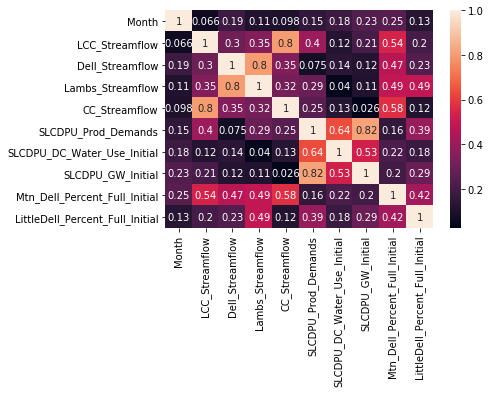

In [172]:
'''
This step check to collinearity among features.
In the instance feature collinearity exceeds the threshold (col_threashold),
the lesser correlated feature to the target will be removed.
These remaining features go to the next step, Recursive Feature Elimination

'''

Col_Check_feat, Col_Check_features = ColinearityRemoval(train_feat, train_targ,col_threshold= .9)

In [173]:
'''
This step uses recursive feature elimination to identify the optimial features for the XGBoost
algorithm and the specific water system target. The function searches from 2 features to the maximum 
collinearity check features to determint the optimial targets features.
'''

Final_FeaturesDF, Final_Features = FeatureSelection(Col_Check_feat, train_targ)

Using RFE to determine optimial features, scoring is:
>2 -1.817 (0.050)
>3 -1.762 (0.045)
>4 -1.683 (0.038)
>5 -1.664 (0.038)
>6 -1.654 (0.034)
>7 -1.644 (0.036)
>8 -1.637 (0.030)
>9 -1.629 (0.045)
   index  n_feat  mean_MAE   std_MAE
0      6     8.0  1.637342  0.029894
1      4     6.0  1.653738  0.034183
2      5     7.0  1.644178  0.036187
3      3     5.0  1.664420  0.038396
4      2     4.0  1.682818  0.038495
5      1     3.0  1.762368  0.044934
6      7     9.0  1.629018  0.045336
7      0     2.0  1.817433  0.050152
[False  True  True False  True  True  True  True  True  True]
[2 1 1 3 1 1 1 1 1 1]
The optimal features are:  ['LCC_Streamflow', 'Dell_Streamflow', 'CC_Streamflow', 'SLCDPU_Prod_Demands', 'SLCDPU_DC_Water_Use_Initial', 'SLCDPU_GW_Initial', 'Mtn_Dell_Percent_Full_Initial', 'LittleDell_Percent_Full_Initial']


In [127]:
#Final_Features.append('Mtn_Dell_Percent_Full_Initial')

In [190]:
'''
This section uses the final features (collinearity removal and RFE) as inputs to determine the 
optimal hyper-parameters for the XGBoost model.
While an exhaustive grid search will identify the optimal hyper-parameters, training speed can be 
reduced by manually working through a small list of each parameter untill no parameter is left at 
the extremes.

'''
Mtn_Dell_Percent_Full =  ['SLCDPU_Surface_Supplies', 'Dell_Streamflow', 'Lambs_Streamflow',
                              'SLCDPU_GW_Initial', 'Mtn_Dell_Percent_Full_Initial']
OG_LDellfeat =  [ 'DOY' ,'Lambs_Streamflow', 'Dell_Streamflow','CC_Streamflow', 'BCC_Streamflow',
                'SLCDPU_Prod_Demands', 'Mtn_Dell_Percent_Full_Initial',
                'LittleDell_Percent_Full_Initial']


Target = targ[0]
Prediction = Target+'_Pred'
Prediction_Rolling = Prediction+'_Rolling'
T_Initial = Target+'_Initial'
#DEveloping MTN Dell Reservoir level Parameters
parameters = {'nthread':[-1], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.01,],
              'max_depth': [3],
              'min_child_weight': [2,4,6],
              'subsample': [.7,],
              'colsample_bytree': [.9],
              "reg_lambda":[0],
              'reg_alpha': [0], 
              'n_estimators': [2000],
               'n_jobs':[-1]}
#Final_FeaturesDF
xgb_grid = GridSearch(parameters, Final_FeaturesDF, train_targ, Target) #train_feat[Mtn_Dell_Percent_Full]

Performing a Grid Search to identify the optimial model hyper-parameters
Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.9833859290441641
{'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 2000, 'n_jobs': -1, 'nthread': -1, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.7}


Model Training
Calibration time 6 s
Saving Model
One-by-one remove the least important features until model accuracy decreases


C:\Users\Ryan\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


prediction time 1 s


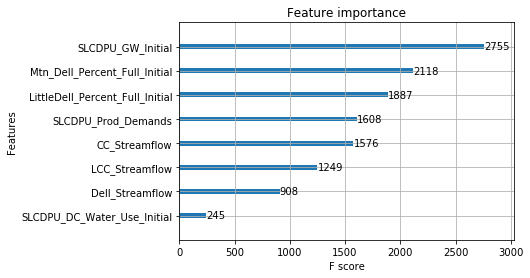

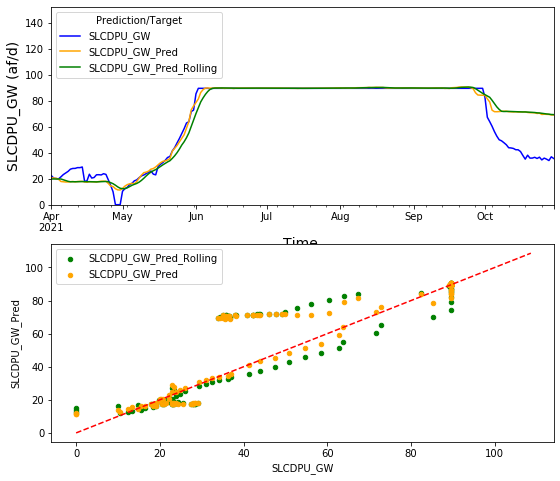

RMSE for predictions:  11.179197558454934 . RMSE for rolling prediction mean:  11.70650145117691


In [191]:
'''
This section uses the identified model parameters to train the model, an example prediction is 
performed to view accuracy.
The model is saved and ready to predict after this step.
'''
#use the non-colinear RFE features

Optparams = xgb_grid.best_params_

Analysis = TrainPredict(Optparams, Target,T_Initial, Prediction, Prediction_Rolling, train_feat[Final_Features],
                        train_targ, test_feat[Final_Features], test_targ)   

PredictionPerformancePlot(Analysis, Target, Prediction, Prediction_Rolling)

In [256]:
#Apply a grid search to optimize results
xgb1 = XGBRegressor()
parameters = {'nthread':[-1], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.05,.1], #so called `eta` value
              'max_depth': [10, 20],
              'min_child_weight': [.1,4],
              'subsample': [0.3,0.7],
              'colsample_bytree': [0.3,0.7],
              "reg_lambda":[.5],
              'reg_alpha': [3],
              'n_estimators': [100],
               'n_jobs':[-1]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=3)
xgb_grid.fit(train_feat, train_targ[Target])

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
0.959364256242445
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 20, 'min_child_weight': 4, 'n_estimators': 100, 'n_jobs': -1, 'nthread': -1, 'objective': 'reg:squarederror', 'reg_alpha': 3, 'reg_lambda': 0.5, 'subsample': 0.7}


In [250]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_weight': 4,
 'n_estimators': 100,
 'n_jobs': -1,
 'nthread': -1,
 'objective': 'reg:squarederror',
 'subsample': 0.3}

In [ ]:
feat = ['DOY' , 'SLCDPU_Prod_Demands', 'Mtn_Dell_Percent_Full', 'LittleDell_Percent_Full','BCC_Streamflow',
        'LCC_Streamflow','CC_Streamflow','Lambs_Streamflow','Day']
        
#'Month', 'SLCDPU_Population','Day','MDell_Initial',  'LDell_Initial','SLCDPU_Surface_Supplies', 'Dell_Streamflow',

targ = ['SLCDPU_GW']#, 'SLCDPU_DC_Water_Use','Mtn_Dell_Percent_Full', 'LittleDell_Percent_Full']

train_feat, train_targ, test_feat, test_targ = ProcessData(Sims, 'Ave_Clim', feat, targ, 2020, 2021, False)

#When using PCA
#train_feat, train_targ, test_feat, test_targ, Targ_scaler = ProcessData(Sims, 'Ave_Clim', feat, targ, 2020, 2021, True)

#from sklearn.decomposition import PCA
#pca = PCA(n_components=9)
#train_feat = pca.fit_transform(train_feat)
#train_feat = pd.DataFrame(data = train_feat
#             , columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])
#test_feat = pca.transform(test_feat)
#test_feat = pd.DataFrame(data = test_feat
#             , columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'])


In [ ]:
#Find the historical RRV, the jenks breaks will use this
RRV = TargetRRV(Hist, 'Hist', Clim_Scenario,'Mtn_Dell_Percent_Full_diff', 'Mtn_Dell_Percent_Full',
                                  Historical_Max_Daily_MDell, RRV, years)
RRV= TargetRRV(Hist, 'Hist', Clim_Scenario,'LittleDell_Percent_Full_diff', 'LittleDell_Percent_Full', 
                                  Historical_Max_Daily_LDell, RRV, years)
RRV= TargetRRV(Hist, 'Hist', Clim_Scenario,'SLCDPU_GW_diff', 'SLCDPU_GW', 
                                  Historical_Max_Daily_GW, RRV, years)
RRV= TargetRRV(Hist, 'Hist', Clim_Scenario,'SLCDPU_DC_Water_Use_diff', 'SLCDPU_DC_Water_Use',
                                  Historical_Max_Daily_DC, RRV, years)

#Climate Simulations
for clim in Predictions:
    RRV= TargetRRV(Predictions[clim], 'SLC_WSM', clim,'Mtn_Dell_Percent_Full_diff', 
                                            'Mtn_Dell_Percent_Full',  Historical_Max_Daily_MDell, RRV, [2021])

    RRV = TargetRRV(Predictions[clim], 'SLC_WSM', clim,'LittleDell_Percent_Full_diff',
                                            'LittleDell_Percent_Full',  Historical_Max_Daily_LDell, RRV, [2021])
    
    RRV= TargetRRV(Predictions[clim], 'SLC_WSM', Clim_Scenario,'SLCDPU_GW_diff', 'SLCDPU_GW', 
                                  Historical_Max_Daily_GW, RRV, [2021])
    
    RRV= TargetRRV(Predictions[clim], 'SLC_WSM', Clim_Scenario,'SLCDPU_DC_Water_Use_diff', 'SLCDPU_DC_Water_Use',
                                  Historical_Max_Daily_DC, RRV, [2021])



    RRF = TargetRRV(Predictions['Ave_Clim'], 'XGB_WSM', Clim_Scenario,'Mtn_Dell_Percent_Full_Pred_diff',
                                              'Mtn_Dell_Percent_Full_Pred',  Historical_Max_Daily_MDell, RRV, [2021])

    RRV = TargetRRV(Predictions['Ave_Clim'], 'XGB_WSM', Clim_Scenario,'LittleDell_Percent_Full_Pred_diff',
                                          'LittleDell_Percent_Full_Pred',  Historical_Max_Daily_LDell, RRV, [2021])
    
    RRV= TargetRRV(Predictions[clim], 'XGB_WSM', Clim_Scenario,'SLCDPU_GW_Pred_diff', 'SLCDPU_GW_Pred', 
                                  Historical_Max_Daily_GW, RRV, [2021])
    
    RRV= TargetRRV(Predictions[clim], 'XGB_WSM', Clim_Scenario,'SLCDPU_DC_Water_Use_Pred_diff', 'SLCDPU_DC_Water_Use_Pred',
                                  Historical_Max_Daily_DC, RRV, [2021])
